In [1]:
# Install the library for the F1 developer API: http://ergast.com/mrd/
!python -m pip install pyergast

In [2]:
# Import the necessary libraries
import requests
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import timedelta
from pyergast import pyergast
from collections import defaultdict
import os
%matplotlib inline

In [3]:
# Function for Driver to the corresponding colour
def assign_color(val_type, values):
    cl = []
    for val in values:
        if val_type == 'drivers':  abbr = val.split()[-1].upper()[0:3]
        elif val_type == 'teams':  abbr = val[0:4].upper()
        if abbr in ['ALFA','BOT','ZHO']:         cl.append('#900000')
        elif abbr in ['HAAS','SCH','MAG']:       cl.append('#ffffff')
        elif abbr in ['ASTO','VET','STR','HÜL']: cl.append('#006f62')
        elif abbr in ['WILL','ALB','LAT','VRI']: cl.append('#0072ff')
        elif abbr in ['ALPH','GAS','TSU']:       cl.append('#2b5962')
        elif abbr in ['MCLA','RIC','NOR']:       cl.append('#ff8700')
        elif abbr in ['RED ','VER','PÉR']:       cl.append('#0600f0')
        elif abbr in ['FERR','LEC','SAI']:       cl.append('#cb0000')
        elif abbr in ['MERC','HAM','RUS']:       cl.append('#00d2bd')
        elif abbr in ['ALPI','ALO','OCO']:       cl.append('#0090ff')
    return cl

In [4]:
# Call http://ergast.com/mrd/ to get the fastest lap and sprint points, because pyergast doesn't support it
def get_fastest_lap(year, race):
    assert year and race, 'You must specify both a year and a race for the fastest lap function'
    url = f"https://ergast.com/api/f1/{year}/{race}/fastest/1/results.json?limit=1000"
    
    r = requests.get(url)
    assert r.status_code == 200, 'Cannot connect to Ergast API. Check your inputs.'
    fastest_lap = r.json()
    if len(fastest_lap["MRData"]["RaceTable"]["Races"]) > 0:
        driver_no = fastest_lap["MRData"]["RaceTable"]["Races"][0]["Results"][0]["number"]
        return str(driver_no)
    else:
        return None

def get_sprint_points(year, race):
    assert year and race, 'You must specify both a year and a race for the sprint race'
    assert year >= 2021, "Sprint races were introduced in 2021 BRITISH GRAND PRIX"
    url = f"https://ergast.com/api/f1/{year}/{race}/sprint.json?limit=1000"
    
    r = requests.get(url)
    assert r.status_code == 200, 'Cannot connect to Ergast API. Check your inputs.'
    sprintRace = r.json()
    sprintRace = sprintRace["MRData"]["RaceTable"]["Races"][0]["SprintResults"]
    driverPoints = defaultdict(int)
    for idx, row in enumerate(sprintRace):
        if int(row["points"]) > 0:
            driverPoints[row["number"]] = int(row["points"])

    return driverPoints    

In [5]:
# Helper functions to load the pandas Dataframes
def get_calendar(season):
    scheduleFileName = "calendar.csv"
    if os.path.exists(scheduleFileName):
        # print(f"The {scheduleFileName} file is already present!")
        schedule = pd.read_csv(scheduleFileName)
        schedule.drop(["Unnamed: 0"], axis=1, inplace=True)
    else:
        schedule = pyergast.get_schedule(year=season)
        schedule.to_csv(scheduleFileName)
    
    return schedule

def get_results(season):
    schedule = get_calendar(season=season)
    resultsFileName = "raceResults.csv"
    if os.path.exists(resultsFileName):
        # print(f"The {resultsFileName} file is already present!")
        currRaceResults = pd.read_csv(resultsFileName)
        currRaceResults.drop(["Unnamed: 0"], axis=1, inplace=True)
    else:
        for index, row in schedule.iterrows():
            currRaceResults = pyergast.get_race_result(year=season, race=row["round"])
            
            currRaceResults.set_index("number", inplace=True)
            currRaceResults["Fastest lap"] = ["NO"] * len(currRaceResults)
            fastestDriver = get_fastest_lap(year=season, race=row["round"])
            if fastestDriver is not None:
                currRaceResults.loc[fastestDriver, "Fastest lap"] = "YES"
            
            if not pd.isna(row["Sprint"]):
                sprintPoints = get_sprint_points(year=season, race=row["round"])
                for driver, points in sprintPoints.items():
                    currRaceResults.loc[driver, "points"] = str(int(currRaceResults.loc[driver, "points"]) + points)

            currRaceResults.reset_index(inplace=True)
            currRaceResults["raceName"] = [row["raceName"]] * len(currRaceResults)

            currRaceResults.drop(["positionText", "driverID", "nationality", "constructorID"], axis=1, inplace=True)
            currRaceResults.rename(columns={"grid": "Qualified"}, inplace=True)

            cols = currRaceResults.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            currRaceResults = currRaceResults[cols]
            hdr = False  if os.path.isfile(resultsFileName) else True
            currRaceResults.to_csv(resultsFileName, mode='a', header=hdr)
    
    return currRaceResults

In [6]:
# Create or read the files for the Season Analysis
season = 2022
calendar = get_calendar(season=season)
raceResults = get_results(season=season)

In [7]:
calendar[["round", "raceName", "locality", "country", "date", "time", "Sprint"]].set_index("round")

,raceName,locality,country,date,time,Sprint
round,,,,,,
1,Bahrain Grand Prix,Sakhir,Bahrain,2022-03-20,15:00:00Z,NaN
2,Saudi Arabian Grand Prix,Jeddah,Saudi Arabia,2022-03-27,17:00:00Z,NaN
3,Australian Grand Prix,Melbourne,Australia,2022-04-10,05:00:00Z,NaN
4,Emilia Romagna Grand Prix,Imola,Italy,2022-04-24,13:00:00Z,"{'date': '2022-04-23', 'time': '14:30:00Z'}"
5,Miami Grand Prix,Miami,USA,2022-05-08,19:30:00Z,NaN
6,Spanish Grand Prix,Montmeló,Spain,2022-05-22,13:00:00Z,NaN
7,Monaco Grand Prix,Monte-Carlo,Monaco,2022-05-29,13:00:00Z,NaN
8,Azerbaijan Grand Prix,Baku,Azerbaijan,2022-06-12,11:00:00Z,NaN
9,Canadian Grand Prix,Montreal,Canada,2022-06-19,18:00:00Z,NaN


In [8]:
# Get the Grand Prix Winners
def get_time(data):
    for index, row in data.items():
        rowDict = ast.literal_eval(row)
        data[index] = rowDict["time"]
    return

winners = raceResults[raceResults["position"] == 1].reset_index().drop(["points", "position", "laps", "index", "status", "number"], axis=1)
winners = winners.rename(columns={"raceName": "Track", "driver": "Driver", "constructor": "Constructor"})
get_time(winners["Time"])

col = ["Track", "Driver", "Constructor", "Time", "Fastest lap", "Qualified"]
winners = winners[col]
winners.set_index("Track", inplace=True)
winners

C:\Users\user\AppData\Local\Temp\ipykernel_13868\1523307465.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[index] = rowDict["time"]


,Driver,Constructor,Time,Fastest lap,Qualified
Track,,,,,
Bahrain Grand Prix,Charles Leclerc,Ferrari,1:37:33.584,YES,1
Saudi Arabian Grand Prix,Max Verstappen,Red Bull,1:24:19.293,NO,4
Australian Grand Prix,Charles Leclerc,Ferrari,1:27:46.548,YES,1
Emilia Romagna Grand Prix,Max Verstappen,Red Bull,1:32:07.986,YES,1
Miami Grand Prix,Max Verstappen,Red Bull,1:34:24.258,YES,3
Spanish Grand Prix,Max Verstappen,Red Bull,1:37:20.475,NO,2
Monaco Grand Prix,Sergio Pérez,Red Bull,1:56:30.265,NO,3
Azerbaijan Grand Prix,Max Verstappen,Red Bull,1:34:05.941,NO,3
Canadian Grand Prix,Max Verstappen,Red Bull,1:36:21.757,NO,1


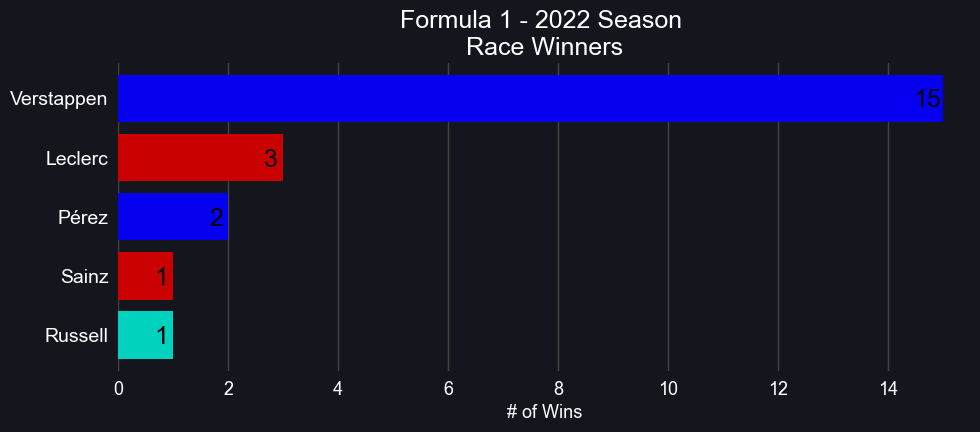

In [20]:
# Same information on a plot
winnerCnt = winners['Driver'].value_counts()
c = assign_color('drivers', winnerCnt.index)
plt.figure(figsize=(11,4))
plt.style.use('seaborn-v0_8')
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = '#15151e'
plt.rcParams['figure.facecolor'] = '#15151e'
plt.rcParams['grid.color'] = '#444444'

plt.barh([driver.split()[1] for driver in winnerCnt.index], winnerCnt.values, color=c)
for i in range(len(winnerCnt.values)):
    if winnerCnt.values[i] > 10:
        plt.text(winnerCnt.values[i] - 0.55, i + 0.15, winnerCnt.values[i], color='k', fontsize=18)
    else:
        plt.text(winnerCnt.values[i] - 0.35, i + 0.15, winnerCnt.values[i], color='k', fontsize=18)

plt.axis([0, max(winnerCnt.values) + 0.5, len(winnerCnt) - 0.4, -0.6])
plt.title(f"Formula 1 - {season} Season \nRace Winners", fontsize=18)
plt.xlabel("# of Wins", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.show()

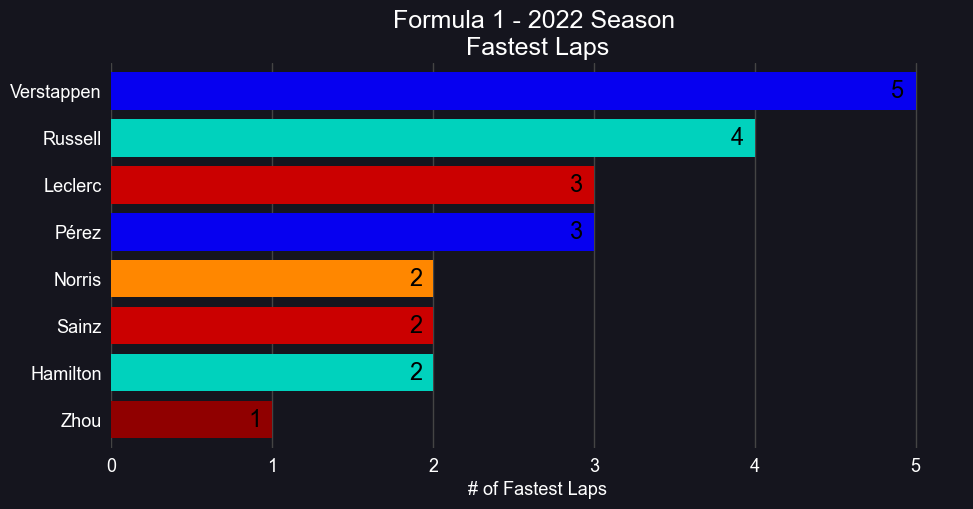

In [10]:
# Get the drivers with the Fastest Laps
fastestLaps = raceResults[raceResults['Fastest lap'] == 'YES']
fastestLaps = fastestLaps.rename(columns={'position':'Finish Position', "driver": "Driver", "constructor": "Constructor"})
fastestLaps.set_index('raceName')
fastestLapCnt = fastestLaps['Driver'].value_counts()
c = assign_color('drivers', fastestLapCnt.index)
plt.figure(figsize=(11,5))
plt.barh([driver.split()[1] for driver in fastestLapCnt.index], fastestLapCnt.values, color=c)
for i in range(len(fastestLapCnt.values)):
    plt.text(fastestLapCnt.values[i] - 0.15, i + 0.15, fastestLapCnt.values[i], color='k', fontsize=17)

plt.axis([0, max(fastestLapCnt.values) + 0.3, len(fastestLapCnt) - 0.4, -0.6])
plt.title(f"Formula 1 - {season} Season \nFastest Laps", fontsize=18)
plt.xlabel("# of Fastest Laps", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis='y')
plt.show()

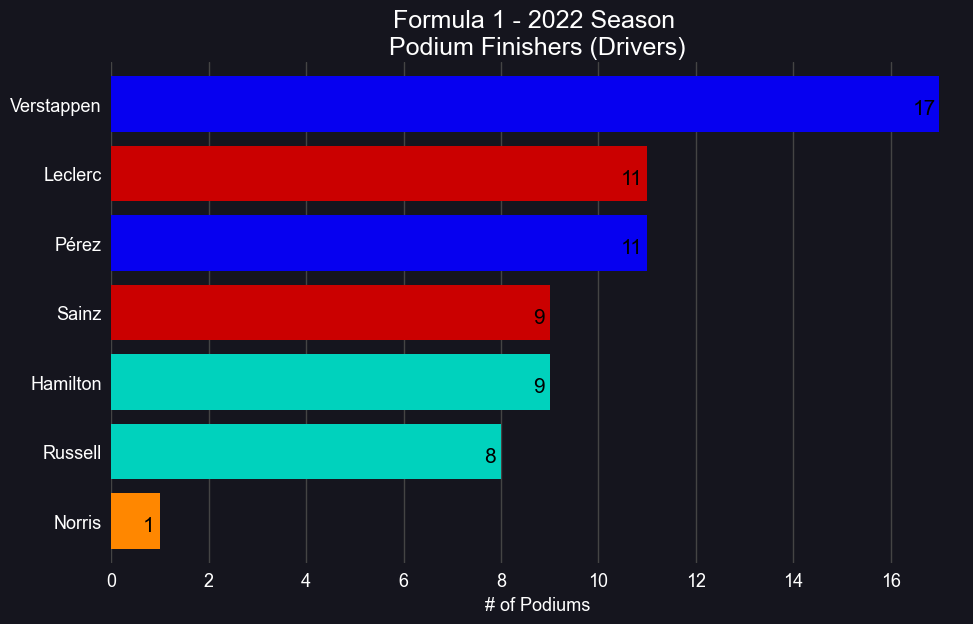

In [11]:
# Count the Drivers podiums
podiums = raceResults[raceResults['position'].isin([1, 2, 3])]
podiumsCnt = podiums['driver'].value_counts()
c = assign_color('drivers', podiumsCnt.index)
plt.figure(figsize=(11,6.5))
plt.barh([driver.split()[1] for driver in podiumsCnt.index], podiumsCnt.values, color=c)
for i in range(len(podiumsCnt.values)):
    if podiumsCnt.values[i] > 10:
        plt.text(podiumsCnt.values[i] - 0.55, i + 0.15, podiumsCnt.values[i], color='k', fontsize=15)
    else:
        plt.text(podiumsCnt.values[i] - 0.35, i + 0.15, podiumsCnt.values[i], color='k', fontsize=15)

plt.axis([0, max(podiumsCnt) + 0.5, len(podiumsCnt) - 0.4, -0.6])
plt.title(f"Formula 1 - {season} Season \nPodium Finishers (Drivers)", fontsize=18)
plt.xlabel("# of Podiums", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis='y')
plt.show()

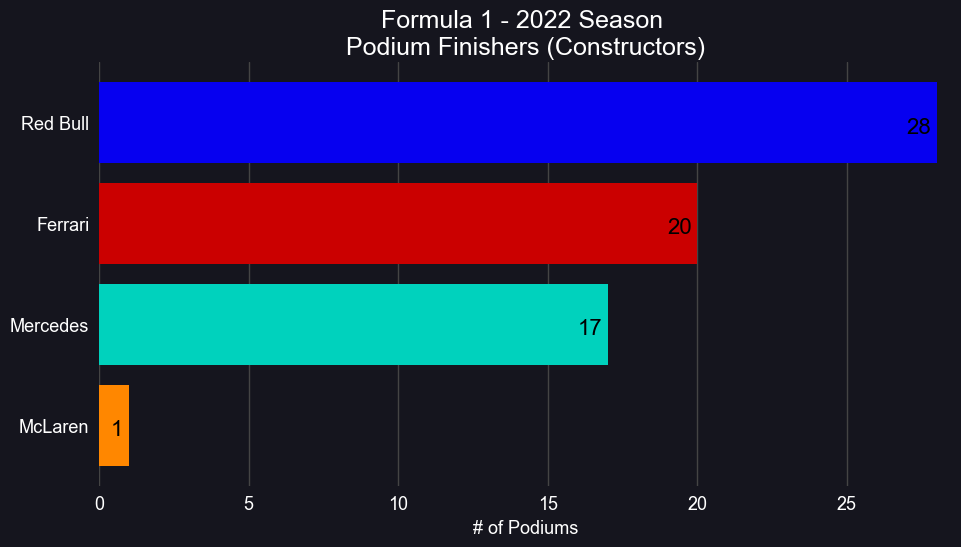

In [12]:
# Count the Constructors podiums
podiumsCntTeam = podiums['constructor'].value_counts()
c = assign_color('teams', podiumsCntTeam.index)
plt.figure(figsize=(11,5.5))
plt.barh(podiumsCntTeam.index, podiumsCntTeam.values, color=c)
for i in range(len(podiumsCntTeam.values)):
    if podiumsCntTeam.values[i] >= 10:  sh = 1
    else:   sh = 0.6
    plt.text(podiumsCntTeam.values[i] - sh, i + 0.1, podiumsCntTeam.values[i], color='k', fontsize=16)

plt.axis([0,max(podiumsCntTeam.values) + 0.5,len(podiumsCntTeam) - 0.4, -0.6])
plt.title(f"Formula 1 - {season} Season \nPodium Finishers (Constructors)", fontsize=18)
plt.xlabel("# of Podiums", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis='y')
plt.show()

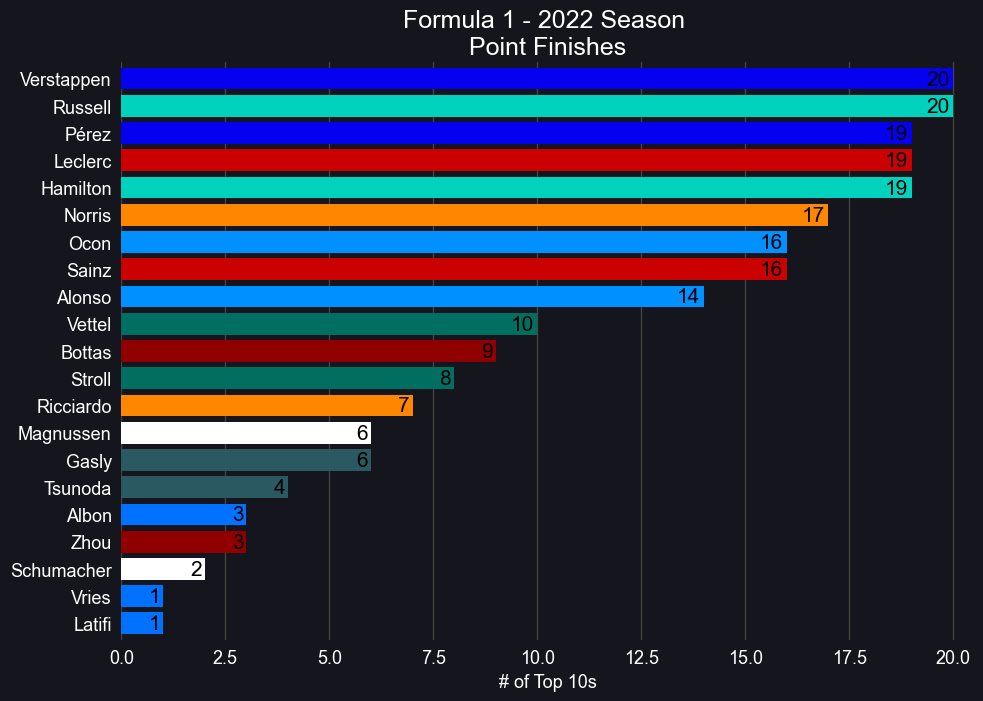

In [13]:
# Count the Drivers point finishes
top10 = range(1,11)
topTenFinishes = raceResults[raceResults['position'].isin(top10)]['driver'].value_counts()
c = assign_color('drivers', topTenFinishes.index)
plt.figure(figsize=(11, 7.5))
plt.barh([driver.split()[-1] for driver in topTenFinishes.index], topTenFinishes.values, color=c)
for i in range(len(topTenFinishes.values)):
    if topTenFinishes.values[i] >= 10:  sh = 0.65
    else:   sh = 0.35
    plt.text(topTenFinishes.values[i] - sh, i + 0.23, topTenFinishes.values[i], color='k', fontsize=15)

plt.axis([0, max(topTenFinishes.values) + 0.5, len(topTenFinishes) - 0.4, -0.6])
plt.title(f"Formula 1 - {season} Season \nPoint Finishes", fontsize=18)
plt.xlabel("# of Top 10s", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis='y')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_13868\3407758774.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sprintQualiResults["index"][idx] = raceResults[raceResults["number"] == int(num)]["driver"].unique()[0]


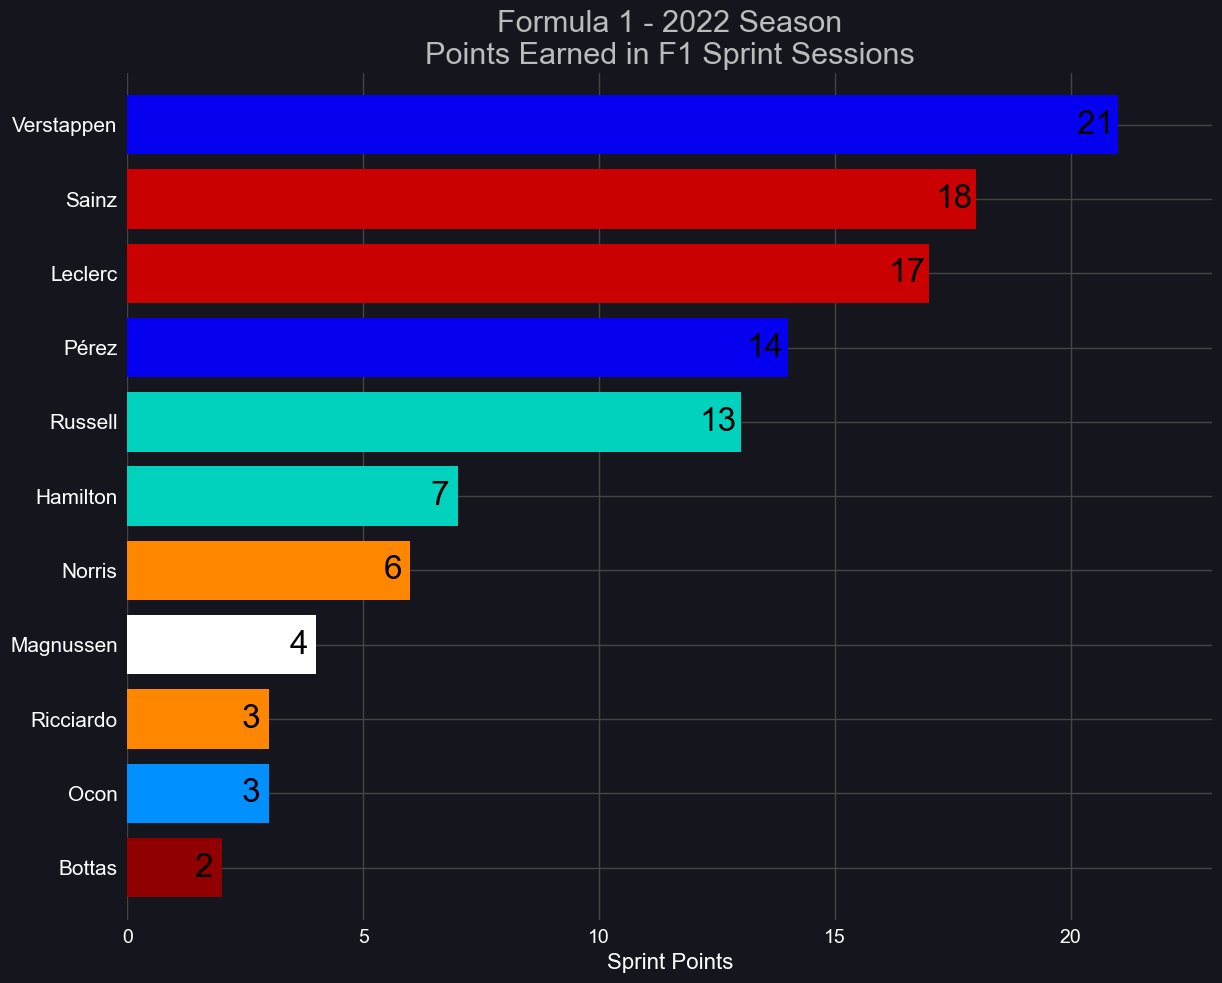

In [14]:
# Points earned on Sprints
sprintPoints = defaultdict(int)
schedule = get_calendar(season=season)
for index, row in schedule.iterrows():
    if not pd.isna(row["Sprint"]):
        currentSprintPoints = get_sprint_points(year=season, race=row["round"])
        for driver, points in currentSprintPoints.items():
            sprintPoints[driver] += currentSprintPoints[driver]

sprintQualiResults = pd.DataFrame.from_dict(sprintPoints, orient="index", columns=["Points"]).reset_index()
for idx, num in enumerate(sprintQualiResults["index"]):
    sprintQualiResults["index"][idx] = raceResults[raceResults["number"] == int(num)]["driver"].unique()[0]

sprintQualiDriver = sprintQualiResults.sort_values(by=["Points"], ascending=False)
sprintQualiDriver.index = [i for i in range(1, len(sprintQualiDriver) + 1)]
c = assign_color("drivers", sprintQualiDriver['index'])
surnames = [driver.split()[1] for driver in sprintQualiDriver['index']]
plt.figure(figsize=(14, len(sprintQualiDriver)))
plt.axis([0, 23, 10.7, -0.7])
plt.barh(surnames, sprintQualiDriver['Points'], color=c)
for i in range(1, len(sprintQualiDriver) + 1):
    if sprintQualiDriver['Points'][i] > 10:
        plt.text(sprintQualiDriver['Points'][i] - 0.87, i - 0.88, sprintQualiDriver['Points'][i], fontsize=24, color='k')
    else:
        plt.text(sprintQualiDriver['Points'][i] - 0.57, i - 0.88, sprintQualiDriver['Points'][i], fontsize=24, color='k')

plt.title(f"Formula 1 - {season} Season\nPoints Earned in F1 Sprint Sessions", fontsize=22, color='#bbbbbb')
plt.xlabel('Sprint Points', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [15]:
# Driver Standings
driverStandings = raceResults.groupby(["driver", "constructor"])['points'].sum().sort_values(ascending=False)
driverStandings = driverStandings.reset_index()
driverStandings.rename(columns={"driver": "Driver", "constructor": "Constructor", "points": "Points"}, inplace=True)
driverStandings["Position"] = range(1, len(driverStandings) + 1)
driverStandings.set_index("Position", inplace=True)
driverStandings

,Driver,Constructor,Points
Position,,,
1,Max Verstappen,Red Bull,454
2,Charles Leclerc,Ferrari,308
3,Sergio Pérez,Red Bull,305
4,George Russell,Mercedes,275
5,Carlos Sainz,Ferrari,246
6,Lewis Hamilton,Mercedes,240
7,Lando Norris,McLaren,122
8,Esteban Ocon,Alpine F1 Team,92
9,Fernando Alonso,Alpine F1 Team,81


In [16]:
# Constructor Standings
constructorStandings = raceResults.groupby(["constructor"])['points'].sum()
constructorStandings = constructorStandings.sort_values(ascending=False).reset_index()
constructorStandings.rename(columns={"constructor": "Constructor", "points": "Points"}, inplace=True)
constructorStandings["Position"] = range(1, len(constructorStandings) + 1)
constructorStandings.set_index("Position", inplace=True)
constructorStandings

,Constructor,Points
Position,,
1,Red Bull,759
2,Ferrari,554
3,Mercedes,515
4,Alpine F1 Team,173
5,McLaren,159
6,Alfa Romeo,55
7,Aston Martin,55
8,Haas F1 Team,37
9,AlphaTauri,35


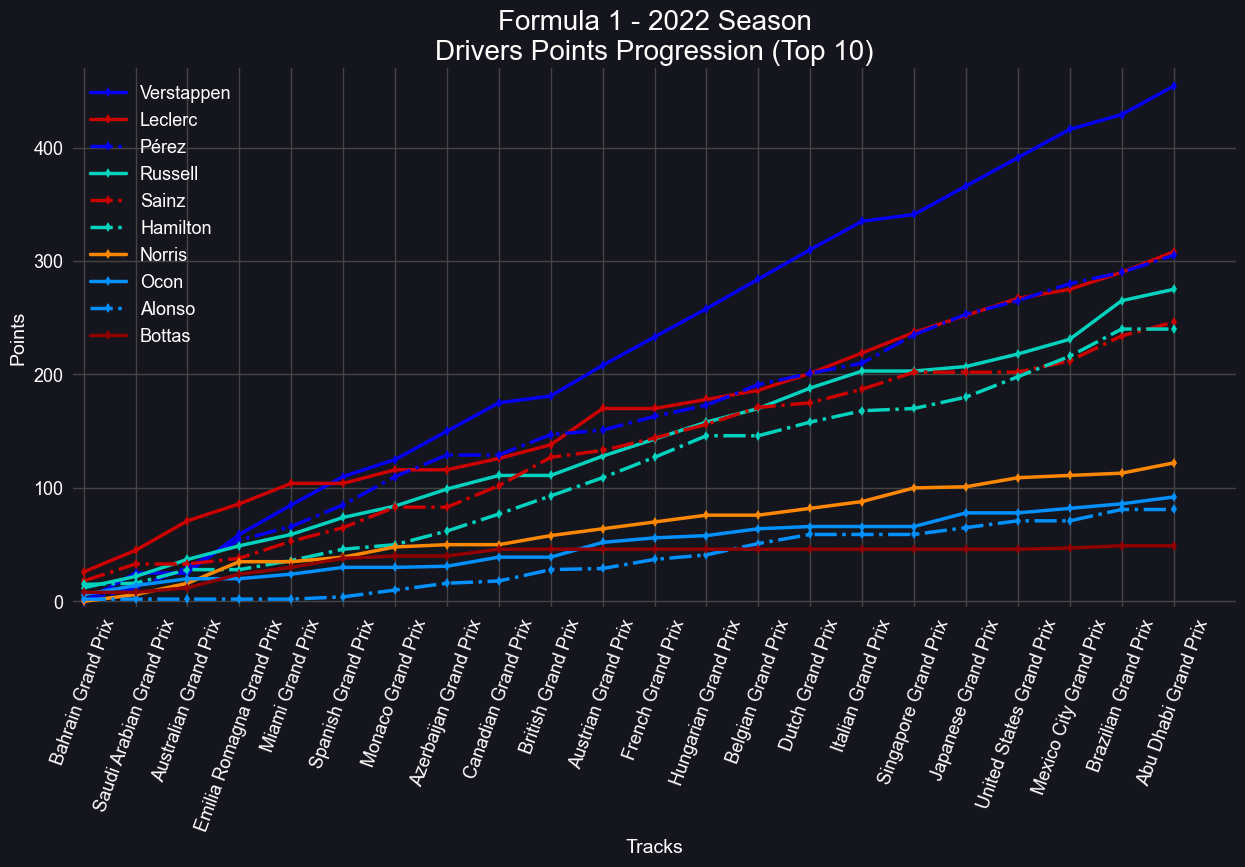

In [17]:
# Drivers Points Progression (Top 10)
GPnames = raceResults['raceName'].unique()
TopTenDrivers = driverStandings.head(10)['Driver'].values
color = assign_color('drivers', TopTenDrivers)
abbr = [driver.split()[1] for driver in TopTenDrivers]

plt.figure(figsize=(15,7))
for i in range(len(TopTenDrivers)):
    ptsPrg = raceResults[raceResults['driver'] == TopTenDrivers[i]]['points'].cumsum().values
    for j in range(len(GPnames)):
        if TopTenDrivers[i] not in raceResults[raceResults['raceName'] == GPnames[j]]['driver'].values:
            ptsPrg = np.insert(ptsPrg, j-1, ptsPrg[j-1])
    if abbr[i].upper()[0:3] in ['PÉR','HAM','SAI', "ALO"]:
        plt.plot(ptsPrg, color=color[i], label=abbr[i], marker='d', markersize=5, linestyle='-.', linewidth=2.5)
    else:  plt.plot(ptsPrg, color=color[i], label=abbr[i], marker='d', markersize=5, linewidth=2.5)

plt.axis([-0.2,22.2,-5,470])
plt.title(f"Formula 1 - {season} Season\nDrivers Points Progression (Top 10)", fontsize=20)
plt.xlabel("Tracks", fontsize=14)
plt.xticks(range(len(GPnames)), GPnames, rotation=70, fontsize=13)
plt.ylabel("Points", fontsize=14)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.show()

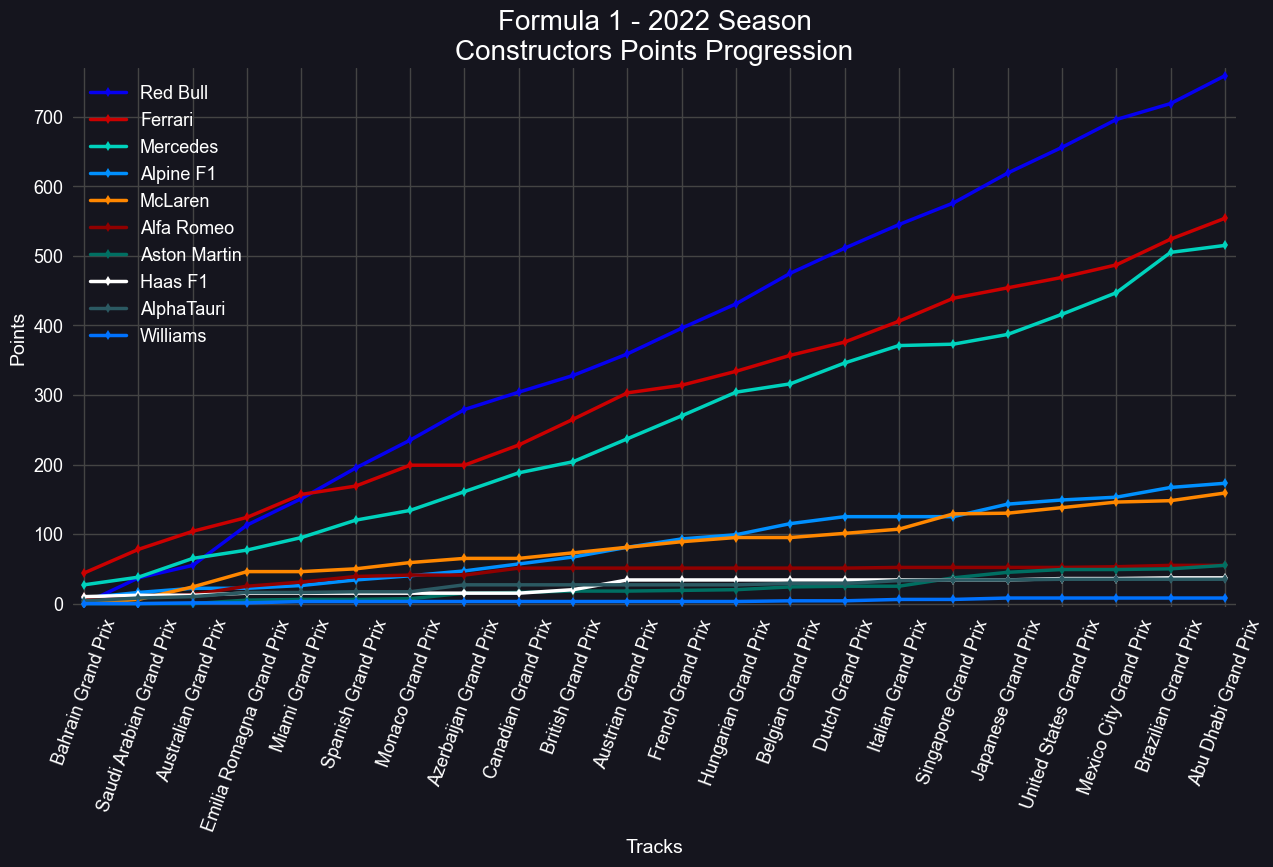

In [18]:
# Constructors Points Progression
trackTeamPts = raceResults.groupby(['raceName','constructor'])['points'].agg('sum')
trackOrder = raceResults['raceName'].unique()
teamOrder = constructorStandings['Constructor'].unique()
color = assign_color('teams',teamOrder)
abbr = [" ".join(team.split()[0:2]) for team in teamOrder]
plt.figure(figsize=(15,7))
for i in range(len(teamOrder)):
    teamPts = []
    for j in range(len(trackOrder)):
        teamPts.append(trackTeamPts.loc[(trackOrder[j], teamOrder[i])])

    teamPts = np.array(teamPts).cumsum()
    plt.plot(teamPts, color=color[i], label=abbr[i], marker='d', markersize=5, linewidth=2.5)

plt.title(f"Formula 1 - {season} Season\nConstructors Points Progression", fontsize=20)
plt.axis([-0.2, 21.2,-5, 770])
plt.xlabel('Tracks', fontsize=14)
plt.xticks(range(len(trackOrder)), trackOrder, rotation=70, fontsize=13)
plt.ylabel('Points', fontsize=14)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)
plt.show()

Total of 74 DNFs have occurred.


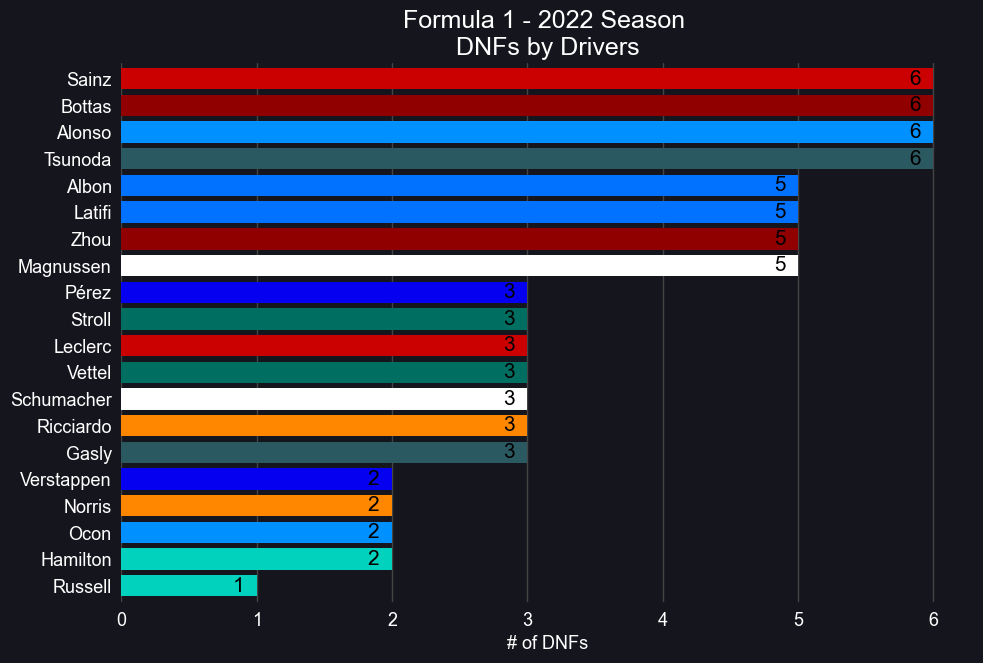

In [19]:
# Drivers DNFs
DNF = raceResults[((raceResults['status'] != 'Finished') & (raceResults['status'] != '+1 Lap') 
                  & (raceResults['status'] != '+2 Laps') & (raceResults['status'] != '+6 Laps'))]
print("Total of {} DNFs have occurred.".format(DNF.shape[0]))
DNFdriver = DNF['driver'].value_counts()
c = assign_color('drivers',DNFdriver.index)
plt.figure(figsize=(11,7))
plt.barh([driver.split()[1] for driver in DNFdriver.index], DNFdriver.values, color=c)
for i in range(len(DNFdriver.values)):
    plt.text(DNFdriver.values[i] - 0.18, i + 0.21, DNFdriver.values[i], color='k', fontsize=15)
plt.axis([0,max(DNFdriver.values) + 0.3, len(DNFdriver) - 0.4, -0.6])
plt.title(f"Formula 1 - {season} Season \nDNFs by Drivers", fontsize=18)
plt.xlabel("# of DNFs", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis='y')
plt.show()